In [1]:
import sys
sys.path.append('../') # or just install the module
sys.path.append('../../flaming-choripan') # or just install the module

In [2]:
from flamingchoripan.files import search_for_filedirs
from lchandler import C_

root_folder = '../../surveys-save'
filedirs = search_for_filedirs(root_folder, fext=C_.EXT_RAW_LIGHTCURVE)

────────────────────────────────────────────────────────────────────────────────────────────────────
found filedirs: (../../surveys-save)
(0) - ../../surveys-save/alerceZTFv7.1/survey-alerceZTFv7.1_bands-gr_mode-onlySNe.ralcds - 2.636[mbs]
────────────────────────────────────────────────────────────────────────────────────────────────────
filedirs after searching with filters: (../../surveys-save)
(0) - ../../surveys-save/alerceZTFv7.1/survey-alerceZTFv7.1_bands-gr_mode-onlySNe.ralcds - 2.636[mbs]
────────────────────────────────────────────────────────────────────────────────────────────────────


In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np
from flamingchoripan.progress_bars import ProgressBar
from flamingchoripan.files import load_pickle, save_pickle
from flamingchoripan.files import get_dict_from_filedir
from lchandler import C_

def load_lcdataset(filedir):
    assert filedir.split('.')[-1]==C_.EXT_RAW_LIGHTCURVE
    return load_pickle(filedir)

filedir = '../../surveys-save/alerceZTFv7.1/survey-alerceZTFv7.1_bands-gr_mode-onlySNe.ralcds'

filedic = get_dict_from_filedir(filedir)
root_folder = filedic['*rootdir*']
cfilename = filedic['*cfilename*']
lcdataset = load_lcdataset(filedir)
print(lcdataset['raw'].keys())
print(lcdataset['raw'].get_random_lcobj(False).keys())
print(lcdataset)

> loading: ../../surveys-save/alerceZTFv7.1/survey-alerceZTFv7.1_bands-gr_mode-onlySNe.ralcds
dict_keys(['data', 'survey', 'description', 'band_names', 'class_names', 'obs_is_flux'])
dict_keys(['days', 'obs', 'obse', 'y', 'synthetic'])
LCDataset:
[raw - samples 2,047]
(*) obs_samples: 65,174 - min_len: 6 - max_dur: 538.8[days] - dur(p50): 52.9[days] - cadence(p50): 1.0[days]
(g) obs_samples: 28,351 - min_len: 0 - max_dur: 538.8[days] - dur(p50): 38.9[days] - cadence(p50): 3.0[days]
(r) obs_samples: 36,823 - min_len: 0 - max_dur: 538.8[days] - dur(p50): 50.9[days] - cadence(p50): 3.0[days]
   |▏       | SLSN - 33/2,047 (1.61%)
   |█████▉  | SNIa - 1,534/2,047 (74.94%)
   |▍       | SNIbc - 103/2,047 (5.03%)
   |█▍      | allSNII - 377/2,047 (18.42%)
────────────────────────────────────────────────────────────────────────────────────────────────────



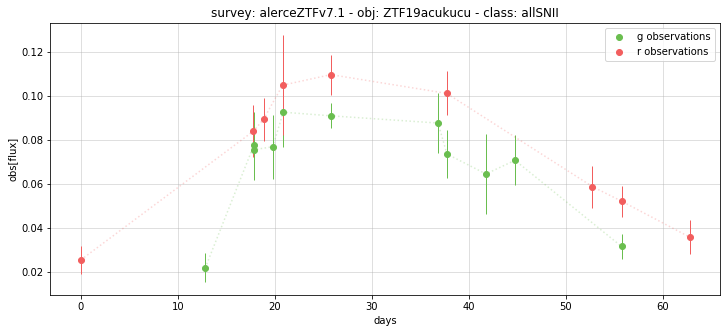

In [5]:
import flamingchoripan.lists as lists
import matplotlib.pyplot as plt
from lchandler.plots.lc import plot_lightcurve

lcset = lcdataset['raw']
lcobj, key = lcset.get_random_lcobj()
fig, ax = plt.subplots(1,1, figsize=(12,5))
for kb,b in enumerate(lcset.band_names):
    plot_lightcurve(ax, lcobj, b, label=f'{b} observations')
ax.set_title(f'survey: {lcset.survey} - obj: {key} - class: {lcset.class_names[lcobj.y]}')
ax.set_xlabel('days')
ax.set_ylabel('obs[flux]')
ax.legend()
ax.grid(alpha=0.5)

In [6]:
%load_ext autoreload
%autoreload 2

new_sets = {
    'raw_train':0.7,
    'raw_val':0.2,
    'raw_test':0.1,
}
lcdataset.split('raw', new_sets)
print(lcdataset)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
LCDataset:
[raw - samples 2,047]
(*) obs_samples: 65,174 - min_len: 6 - max_dur: 538.8[days] - dur(p50): 52.9[days] - cadence(p50): 1.0[days]
(g) obs_samples: 28,351 - min_len: 0 - max_dur: 538.8[days] - dur(p50): 38.9[days] - cadence(p50): 3.0[days]
(r) obs_samples: 36,823 - min_len: 0 - max_dur: 538.8[days] - dur(p50): 50.9[days] - cadence(p50): 3.0[days]
   |▏       | SLSN - 33/2,047 (1.61%)
   |█████▉  | SNIa - 1,534/2,047 (74.94%)
   |▍       | SNIbc - 103/2,047 (5.03%)
   |█▍      | allSNII - 377/2,047 (18.42%)
────────────────────────────────────────────────────────────────────────────────────────────────────
[raw_train - samples 1,431]
(*) obs_samples: 45,614 - min_len: 6 - max_dur: 444.7[days] - dur(p50): 52.9[days] - cadence(p50): 1.0[days]
(g) obs_samples: 19,841 - min_len: 0 - max_dur: 443.9[days] - dur(p50): 38.0[days] - cadence(p50): 3.0[days]
(r) obs_samples: 25,773 - min_len: 0 - max

In [14]:
%load_ext autoreload
%autoreload 2

sigma_clipping_kwargs = {
    'sigma_n':3,
    'sigma_m':5, # 1, 3, 5
    'apply_lower_bound':False,
    'verbose':0,
}
for ks,set_name in enumerate(['raw_train', 'raw_val', 'raw_test']):
    lcdataset.sigma_clipping(set_name, set_name.replace('raw_',''), **sigma_clipping_kwargs)

print(lcdataset)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
LCDataset:
[raw - samples 2,047]
(*) obs_samples: 65,174 - min_len: 6 - max_dur: 538.8[days] - dur(p50): 52.9[days] - cadence(p50): 1.0[days]
(g) obs_samples: 28,351 - min_len: 0 - max_dur: 538.8[days] - dur(p50): 38.9[days] - cadence(p50): 3.0[days]
(r) obs_samples: 36,823 - min_len: 0 - max_dur: 538.8[days] - dur(p50): 50.9[days] - cadence(p50): 3.0[days]
   |▏       | SLSN - 33/2,047 (1.61%)
   |█████▉  | SNIa - 1,534/2,047 (74.94%)
   |▍       | SNIbc - 103/2,047 (5.03%)
   |█▍      | allSNII - 377/2,047 (18.42%)
────────────────────────────────────────────────────────────────────────────────────────────────────
[raw_train - samples 1,431]
(*) obs_samples: 45,614 - min_len: 6 - max_dur: 444.7[days] - dur(p50): 52.9[days] - cadence(p50): 1.0[days]
(g) obs_samples: 19,841 - min_len: 0 - max_dur: 443.9[days] - dur(p50): 38.0[days] - cadence(p50): 3.0[days]
(r) obs_samples: 25,773 - min_len: 0 - max

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


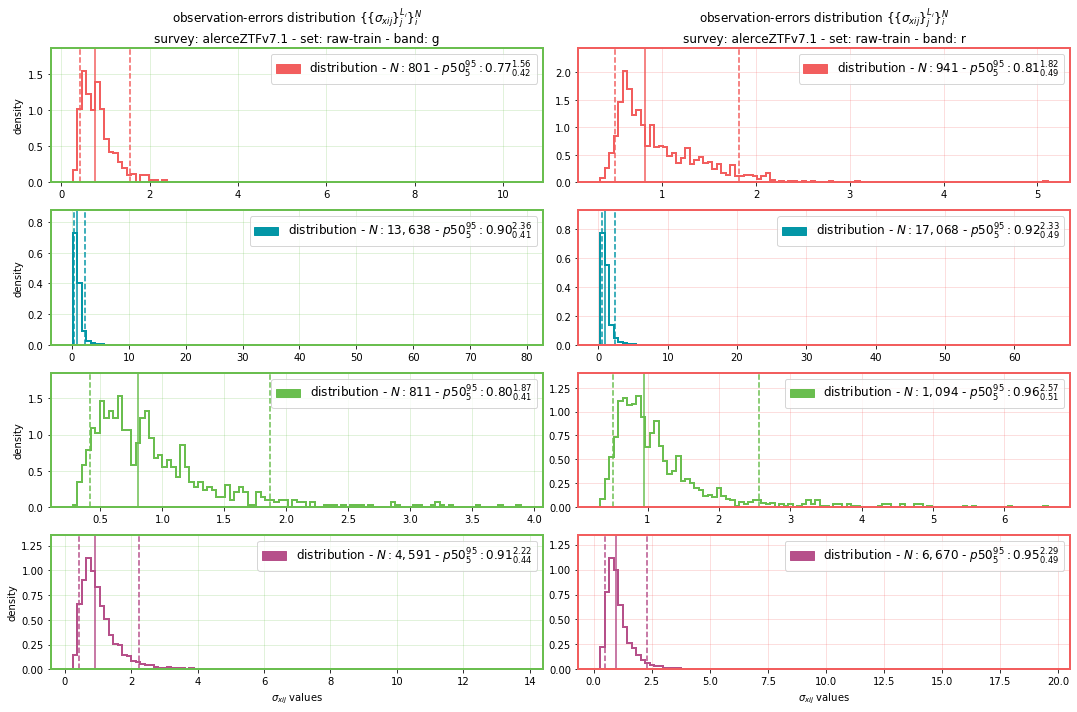

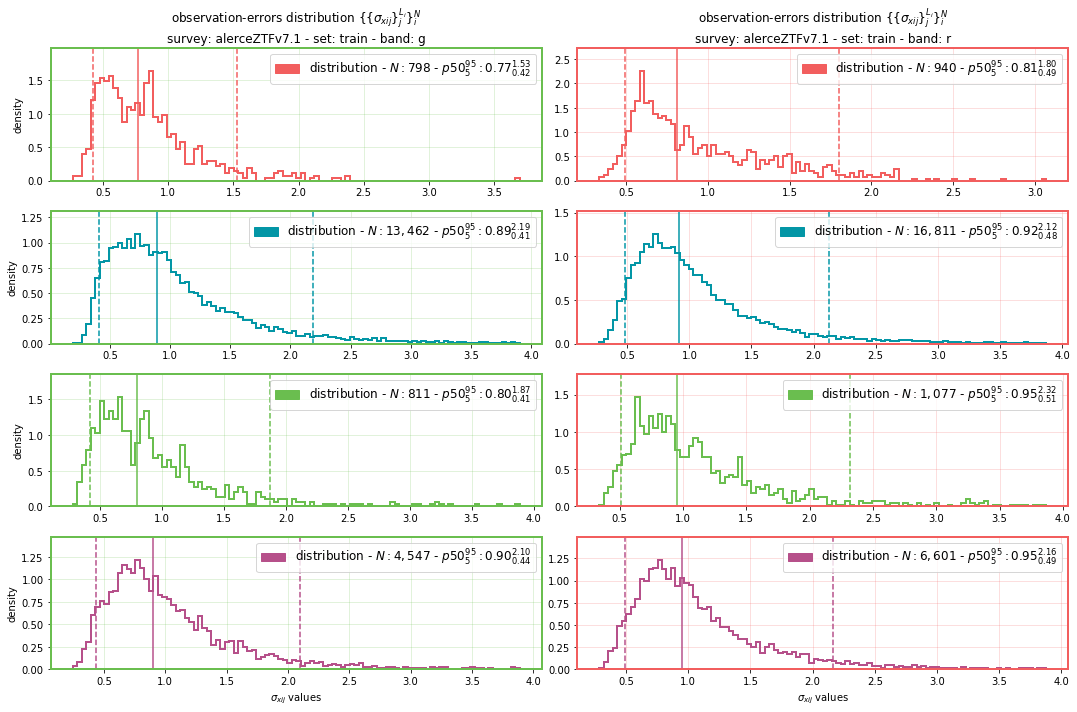

In [8]:
%load_ext autoreload
%autoreload 2
from lchandler.plots.dataset import plot_sigma_distribution

set_name = 'train'
plot_sigma_distribution(lcdataset, f'raw_{set_name}')
plot_sigma_distribution(lcdataset, set_name)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


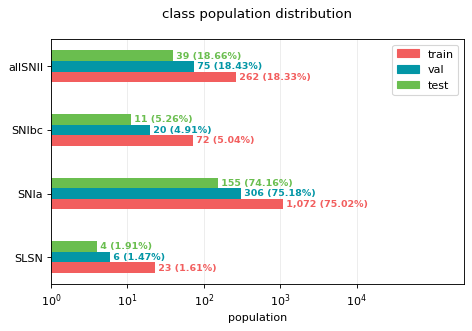

In [19]:
%load_ext autoreload
%autoreload 2
from lchandler.plots.dataset import plot_class_distribution

plot_class_distribution(lcdataset, ['train', 'val', 'test'])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


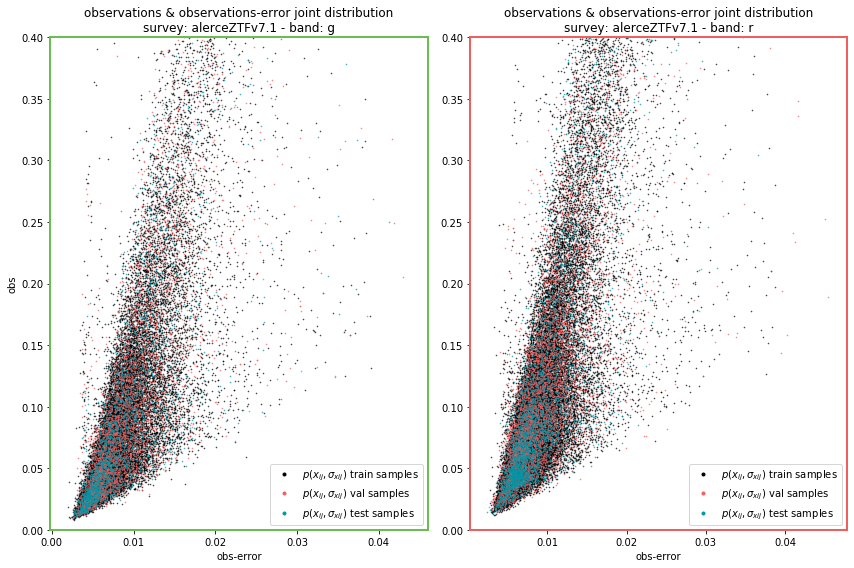

In [11]:
%load_ext autoreload
%autoreload 2
from lchandler.plots.scatters import plot_obs_obse_scatter

plot_obs_obse_scatter(lcdataset, ['train', 'val', 'test'])

In [12]:
from flamingchoripan.files import load_pickle, save_pickle
from lchandler import C_

kfid = 0
new_cfilename = f'{cfilename}_kfid-{kfid}'
save_filedir = f'{root_folder}/{new_cfilename}.{C_.EXT_SPLIT_LIGHTCURVE}'
save_pickle(save_filedir, lcdataset)

> saving: ../../surveys-save/alerceZTFv7.1/survey-alerceZTFv7.1_bands-gr_mode-onlySNe_kfid-0.splcds
